# Chapter 4: Portfolio Optimization in Practice

## Key Concepts

- Introduction to scientific diversification
- Measuring risk contrbutions accross 3 diverse assets
- Introduction to risk parity
- Implementing risk parity portfolios
- Analysing cap-weighted versus better diversified portfolios

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
%matplotlib inline

# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-pastel") 

## Naive Diversification VS Scientific Diversification

### Effective number of constituents

- a quantitative measure of how well balanced any portfolio is

Construct a portfolio in these $N$ assets and a set of $N$ weights $\{w_i\}_{i=1,\dots,N}$.

$$
\text{ENC} := \left(\sum_{i=1}^N w_i^2 \right)^{-1}.
$$


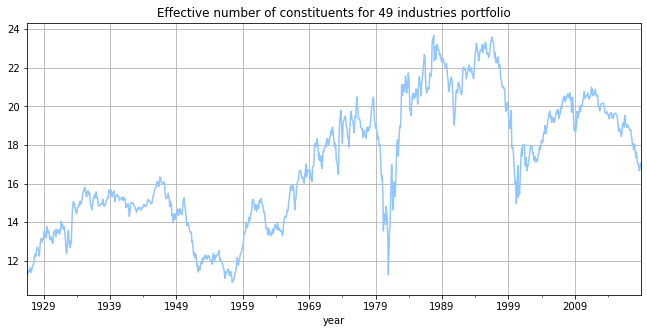

In [2]:
nind = 49
ind_mkt_caps = erk.get_ind_market_caps(n_inds=nind, weights=True)
#tot_mkt_ind  = erk.get_total_market_index(nind=nind)
# compute the ENC
enc = (ind_mkt_caps**2).sum(axis=1)**(-1)

fig, ax = plt.subplots(1,1,figsize=(11,5))
enc.plot(ax=ax, grid=True, title="Effective number of constituents for 49 industries portfolio")
ax.set_xlabel("ENC")
ax.set_xlabel("year")
plt.show()

We see that even if we are investing in $49$ industries, the number of **effective constituents** of the portofolio is much fewer than 49. This is because, since we are holding a cap-weigthed portfolio, there will be many industries with allocation weights close to zero. 

When we apply this measure to some well-known cap-weighted index market benchmarks such as the **S\&P500 Index**, we come to the conclusion that such indices are not necessarily well-balanced, **they tend to be fairly concentrated** (in about only $100$ stocks).

### Balancing the GMV portfolio

The advantage of **GMV portfolio** is that **any expected return estimates** is not required.

However, **tend to be heavily concentrated in low volatiliy components**. 

As a result, the GMV portfolio is a **concentrated portfolio**, i.e., it has a small number of ENCs.

Again, let us construct the GMV portfolio consisting of the $49$ industries (data from $2000$):

In [3]:
# Load returns
ind_rets = erk.get_ind_returns(n_inds= nind)["2000":]
ind_rets.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2000-01,-0.0450,-0.1033,0.1970,-0.0228,-0.0862,-0.1381,0.0391,-0.0062,-0.0651,-0.1138,...,-0.1384,-0.0956,0.0899,-0.1453,-0.0739,-0.0254,-0.0727,0.0140,-0.0681,-0.0036
2000-02,0.0816,-0.0708,-0.0828,-0.1164,-0.0401,0.0042,-0.0195,-0.0061,-0.1157,-0.1278,...,-0.1307,-0.0535,0.0113,-0.0393,-0.1203,-0.1131,-0.1276,0.0309,0.0672,-0.0107
2000-03,0.0426,0.1076,-0.0029,0.0013,0.0511,0.0769,0.1076,0.1312,-0.1426,0.2506,...,0.1265,0.1287,0.0659,0.1436,0.1598,0.1506,0.2287,0.0312,0.1474,-0.0153
2000-04,-0.0761,-0.0408,-0.0080,0.0368,0.0379,0.0027,0.0236,-0.0754,0.0429,0.0430,...,-0.0787,0.0348,-0.0107,-0.0560,0.0382,-0.0285,-0.0040,-0.0725,-0.1256,0.0707
2000-05,-0.0247,0.1806,-0.0724,0.1187,0.1951,0.0115,0.0120,-0.0634,0.0279,-0.0504,...,-0.0212,-0.0363,0.0193,-0.0304,-0.0421,0.0796,0.0731,-0.0341,-0.0694,0.0976


In [4]:
ann_ind_rets = erk.annualize_rets(ind_rets, periods_per_year=12)
cov_mat_rets = erk.sample_cov(ind_rets)
gmv_w = erk.gmv(cov_mat_rets)
enc = (gmv_w**2).sum()**(-1)
print("ENC: {:.2f}".format(enc))

ENC: 7.64


The portfolio, effectively consists of about only $7$ industries (out of total $49$).

### Improving the GMV portfolio

Improve the GMV portfolio by making it more **well-diversified**

**Method One:** Minimize portfolio variance subject to a minimum $\text{ENC}_0$. 



$$
\begin{align}
\text{minimize} \;\;\, &\frac{1}{2}\mathbf{w}^T\Sigma\mathbf{w},    \\
%\mathbf{w}^T\mathbf{1} = 1
\left(\mathbf{w}^T \mathbf{w}\right)^{-1} & = \text{ENC}_0. 
\end{align}
$$


**Method Two:** Max Decorrelation Portfolio

Assume **all portfolio components have the same volatility**, $\sigma_i = \sigma_j = \hat{\sigma}$, for all $i,j$. 
$$
\text{min} \frac{1}{2} \sum_{i,j} w_i, w_j \sigma_i, \sigma_i \rho_{ij}
\Longrightarrow\quad 
\text{min} \sum_{i,j} w_i, w_j \rho_{ij}.
$$


## Risk contributions

The volatiltiy of a portfolio as:

$$
\sigma_p^2 = \sum_{i=1}^N w_i^2\sigma_i^2 + \sum_{i\neq j} w_i w_j \sigma_i \sigma_j \rho_{ij}.
$$

The **risk contribution** of the $i$th asset $p_i$ of the portfolio is given by:
$$
p_i := \frac{ w_i^2\sigma_i^2 + \sum_{i\neq j} w_i w_j \sigma_i \sigma_j \rho_{ij}   }{\sigma_p^2}.
$$


## Risk Parity Portfolio

**Risk parity portfolio** (or the **Equal Risk Contribution (ERC)** portfolio) is the portfolio with **equal risk contribution**

### Effective Number of Correlated Bets (ENCB)


$$
\text{ENCB} := \left(\sum_{i=1}^N p_i^2\right)^{-1}. 
$$

where $p_i$ is the risk contribution of the $i$th asset.


In [5]:
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

rets = ind_rets["2013":][inds]
cov = rets.cov()

In [6]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

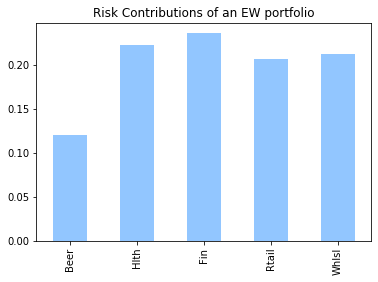

In [7]:
risk_contribution(erk.weight_ew(rets), cov).plot.bar(title="Risk Contributions of an EW portfolio");

In [8]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)


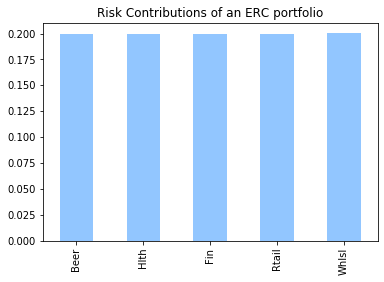

In [9]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [10]:
def weight_erc(r, cov_estimator=erk.sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076


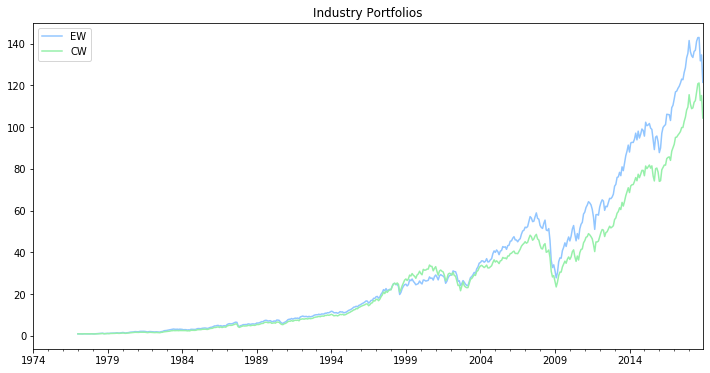

In [11]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's run a backtest of this new weighting scheme we've just developed. Be warned that this will likely take quite some time to run - depending on your computer's CPU horsepower, but on my laptop it took several minutes.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076
ERC-Sample,0.120185,0.149185,-0.872577,7.019237,0.066886,0.096357,0.588203,-0.502950


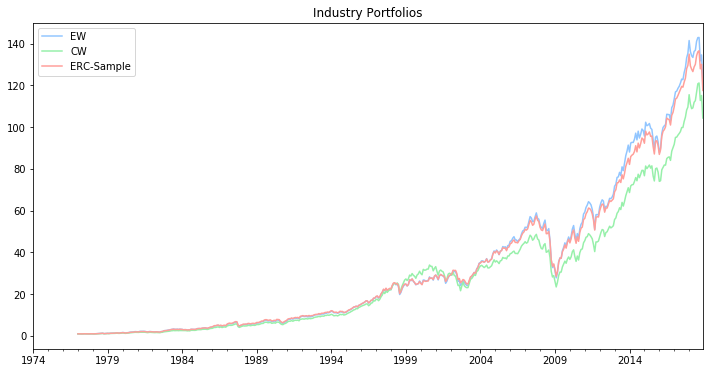

In [12]:
mv_erc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=erk.sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())